In [4]:
# Custom dataset class
import os
import csv
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn.functional as F

# custom dataset on csv files
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']  # Assuming 'PatientID' is the column name in your CSV file

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# plot roc curve
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# test model performance 
def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
     
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}

    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)
    
    

In [2]:
# my net work, the same as jobs
class res101(nn.Module):
    def __init__(self, num_classes=2):
        super(res101, self).__init__()
        self.inplanes = 64  # 初始的inplanes值
        # 定义ResNet-101的前几层，不包括最后的全连接层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 23, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        # 平均池化层
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 分类层
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride))
        self.inplanes = planes * 4  # Bottleneck的输出通道数是planes * 4
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # 将特征图展平
        x = self.fc(x)
        return x

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or inplanes != planes * Bottleneck.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

# ResNet 50


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class ResNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.75):
        super(ResNet, self).__init__()

        self.features = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# ResNet 101


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class ResNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.75):
        super(ResNet, self).__init__()

        # self.features = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.features = models.resnet101(weights=ResNet101_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# ResNet 152

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet152, ResNet152_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class ResNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.75):
        super(ResNet, self).__init__()

        self.features = models.resnet152(weights=ResNet152_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [2]:
# create net
model = ResNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# checkpoint_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/850250a0-e63f-4547-b624-6e25a3524ab3/app_server/FL_global_model.pt'
# checkpoint_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/62839378-2807-46ba-a44f-a25c9181d555/app_server/FL_global_model.pt'
# checkpoint_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/03095e19-151f-486b-9927-8e5fb0e7ccc6/app_server/FL_global_model.pt'
# resnet 50
checkpoint_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/2d47a9c7-6612-4881-b79d-e532e45a16bd/app_server/FL_global_model.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()


odict_keys(['model', 'train_conf'])


ResNet(
  (features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

# Test hospital 100

AFF: 155, ratio: 0.19
NFF: 657, ratio: 0.81
Test Loss: 0.6945, Test Acc: 82.64%
AUC: 0.7300191486227722
Confusion Matrix:
[[582  75]
 [ 66  89]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.90      0.89      0.89       657
         AFF       0.54      0.57      0.56       155

    accuracy                           0.83       812
   macro avg       0.72      0.73      0.72       812
weighted avg       0.83      0.83      0.83       812



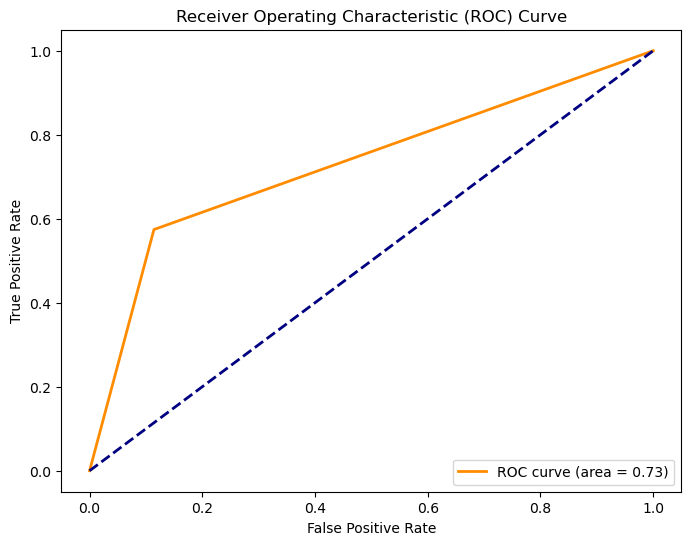

In [5]:
# Resnet 101 on single hospital
# Define your transformations
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create an instance of CustomDataset for testing
test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/6_model_test/hospital100.csv', transform=test_transform)


# For test dataset
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF
print(f"AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")

test_model(model, test_dataset=test_dataset, batch_size=16)


AFF: 28, ratio: 0.16
NFF: 152, ratio: 0.84
Test Loss: 0.1319, Test Acc: 96.11%
AUC: 0.8895676691729323
Confusion Matrix:
[[151   1]
 [  6  22]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.96      0.99      0.98       152
         AFF       0.96      0.79      0.86        28

    accuracy                           0.96       180
   macro avg       0.96      0.89      0.92       180
weighted avg       0.96      0.96      0.96       180



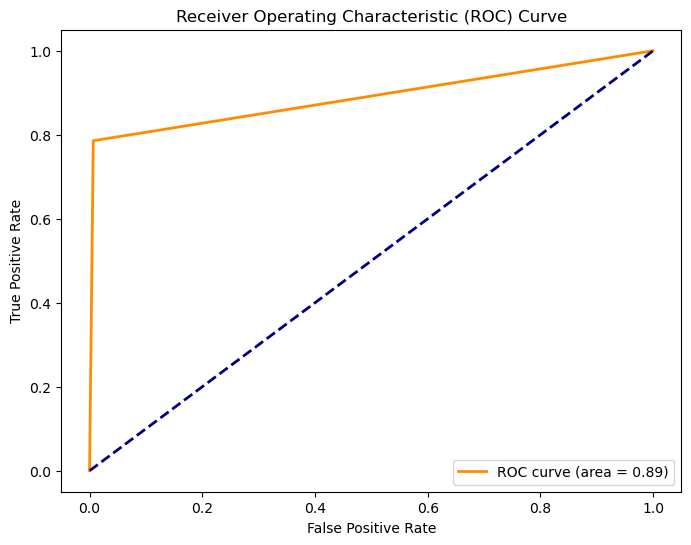

In [15]:
# test dataset
test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/6_model_test/hospital55.csv', transform=test_transform)

# For test dataset
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF
print(f"AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")

test_model(model, test_dataset=test_dataset, batch_size=16)
